In [40]:
# This simulates optimisation for a BTM Bess for a site with: 
# load (and load forecast)
# production (solar) and production forecasst
# one or more battery units

# Objective: Minimise cost of energy imports – revenue from exports + monetised degradation.

# It shows concretely: 
# How the optimiser “decides” when to charge/discharge.
# Computational tractability (runtime on laptop vs cloud scale).
# The impact of degradation cost (e.g. if you price degradation at 2¢/kWh cycled, dispatch shifts).

# It can be extended incrementally to match your production architecture.# Time horizon: 24 hours, 1-hour resolution (24 timesteps).



# Assets:
# 2 or 3 batteries, each with different capacity/power limits, efficiencies, and degradation costs.

# Inputs (simple synthetic data):
# Hourly load profile (e.g. industrial process baseline).
# Hourly PV generation profile.
# Hourly day-ahead prices (could be sinusoidal or pulled from a dataset).

# Constraints:
# SOC dynamics and limits per battery.
# Per-battery charge/discharge power caps.
# Site-level balance (load = PV + batteries + grid).
# Grid import/export allowed (positive = import, negative = export).
# minimum SOC buffer for ancillary services/imbalance

# Outputs 
# Optimal grid import/export profile.
# Per-battery charge/discharge schedule.
# Per-battery SOC trajectories.
# Site-level cost vs. “do nothing” baseline.

# Stretch features - NOT included:

# Binary constraint for non-simultaneous charge/discharge (turns LP optimisation into MILP).
# Cumulative throughput cap to mimic warranty.
# Rolling horizon (reoptimise with updated forecasts).

#     # This emulator was created after the model described here: https://chatgpt.com/share/68bee733-cb1c-8001-85dd-55ecb6bef662

In [38]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

np.random.seed(1)
T = 24  # hours
dt = 1.0
timesteps = np.arange(T)


In [35]:
# Load, PV, price profiles
base_load = 80 + 10*np.sin(2*np.pi*(timesteps-6)/24)
pv = np.maximum(0, 40 * np.sin(np.pi*(timesteps-6)/12))
price = 0.08 + 0.06*np.sin(2*np.pi*(timesteps-16)/24)

# Battery definitions
batteries = [
    {
        "id": "BAT_A",
        "capacity_kWh": 200.0,
        "p_charge_kW": 100.0,
        "p_discharge_kW": 100.0,
        "eta_c": 0.97,
        "eta_d": 0.97,
        "soc_init": 0.5,
        "soc_min": 0.05,
        "soc_max": 0.95,
        "degradation_cost_per_kWh": 0.01,
        "reserve_kWh": 20.0
    },
    {
        "id": "BAT_B",
        "capacity_kWh": 100.0,
        "p_charge_kW": 50.0,
        "p_discharge_kW": 50.0,
        "eta_c": 0.98,
        "eta_d": 0.98,
        "soc_init": 0.6,
        "soc_min": 0.05,
        "soc_max": 0.95,
        "degradation_cost_per_kWh": 0.015,
        "reserve_kWh": 10.0
    }
]

nB = len(batteries)

In [18]:
# Decision variables
ch = [cp.Variable(T, nonneg=True) for _ in range(nB)]
dis = [cp.Variable(T, nonneg=True) for _ in range(nB)]
soc = [cp.Variable(T+1) for _ in range(nB)]
throughput = [cp.Variable(T, nonneg=True) for _ in range(nB)]
G = cp.Variable(T)

constraints = []

# Build constraints per battery
for i, b in enumerate(batteries):
    E = b["capacity_kWh"]
    reserve = b["reserve_kWh"]
    # Effective SOC min/max keep symmetric reserve out of scheduling
    soc_min_eff = b["soc_min"] * E + reserve/2.0
    soc_max_eff = b["soc_max"] * E - reserve/2.0
    soc_init_kWh = b["soc_init"] * E
    constraints += [soc[i][0] == soc_init_kWh]
    for t in range(T):
        constraints += [
            soc[i][t+1] == soc[i][t] + b["eta_c"] * ch[i][t] * dt - (1.0 / b["eta_d"]) * dis[i][t] * dt
        ]
        constraints += [ch[i][t] <= b["p_charge_kW"], dis[i][t] <= b["p_discharge_kW"]]
        constraints += [throughput[i][t] >= ch[i][t] + dis[i][t]]
        constraints += [soc[i][t+1] >= soc_min_eff, soc[i][t+1] <= soc_max_eff]
# Build site-level power balance
for t in range(T):
    # Power balance: load = PV + sum(dis) - sum(ch) + G
    total_dis = sum(dis[i][t] for i in range(nB))
    total_ch = sum(ch[i][t] for i in range(nB))
    constraints += [base_load[t] == pv[t] + total_dis - total_ch + G[t]]



In [42]:
energy_cost = cp.sum(cp.multiply(price, G))
deg_cost = sum(b["degradation_cost_per_kWh"] * cp.sum(throughput[i]) for i,b in enumerate(batteries))
objective = cp.Minimize(energy_cost + deg_cost)


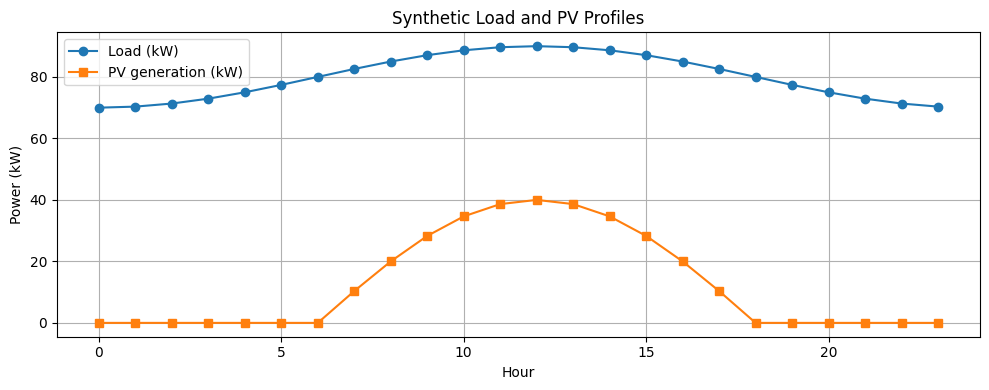

In [44]:
# Plot inputs: load and generation
plt.figure(figsize=(10,4))
plt.plot(timesteps, base_load, label="Load (kW)", marker='o')
plt.plot(timesteps, pv, label="PV generation (kW)", marker='s')
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.title("Synthetic Load and PV Profiles")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.OSQP)
print("Solve status:", prob.status)


Solve status: optimal


In [31]:
# Collect results
df = pd.DataFrame({"hour": timesteps, "load_kW": base_load, "pv_kW": pv, "price_eur_per_kWh": price})
df["grid_import_kW"] = G.value
for i, b in enumerate(batteries):
    df[f"ch_{b['id']}_kW"] = ch[i].value
    df[f"dis_{b['id']}_kW"] = dis[i].value
    df[f"soc_{b['id']}_kWh"] = soc[i].value[1:]
    df[f"throughput_{b['id']}_kWh"] = throughput[i].value

total_deg = sum(b["degradation_cost_per_kWh"] * np.sum(df[f"throughput_{b['id']}_kWh"]) for i,b in enumerate(batteries))
total_energy_cost = np.sum(df["grid_import_kW"] * df["price_eur_per_kWh"])
print("Solve status:", prob.status)
print(f"Total energy cost (€/day): {total_energy_cost:.2f}")
print(f"Total degradation cost (€/day): {total_deg:.2f}")
print(f"Total cost (€/day): {total_energy_cost + total_deg:.2f}")


df.to_csv("da_schedule_with_reserve.csv", index=False)
print("Saved schedule to da_schedule_with_reserve.csv")

Solve status: optimal
Total energy cost (€/day): 91.42
Total degradation cost (€/day): 7.11
Total cost (€/day): 98.53
Saved schedule to da_schedule_with_reserve.csv


In [33]:
df

,hour,load_kW,pv_kW,price_eur_per_kWh,grid_import_kW,ch_BAT_A_kW,dis_BAT_A_kW,soc_BAT_A_kWh,throughput_BAT_A_kWh,ch_BAT_B_kW,dis_BAT_B_kW,soc_BAT_B_kWh,throughput_BAT_B_kWh
0,0,70.000000,0.000000e+00,0.131962,-56.600051,1.353350e-04,7.760019e+01,19.999933,7.760037e+01,0.000000e+00,4.899998e+01,10.000007,4.899996e+01
1,1,70.340742,0.000000e+00,0.122426,70.340786,2.440746e-05,0.000000e+00,19.999982,0.000000e+00,0.000000e+00,2.473875e-06,10.000002,1.181318e-08
2,2,71.339746,0.000000e+00,0.110000,71.339758,6.684170e-06,0.000000e+00,19.999995,0.000000e+00,0.000000e+00,6.078806e-07,10.000001,2.897531e-09
3,3,72.928932,0.000000e+00,0.095529,72.928937,2.146285e-06,0.000000e+00,20.000000,0.000000e+00,5.340248e-08,0.000000e+00,10.000001,0.000000e+00
4,4,75.000000,0.000000e+00,0.080000,75.000005,1.842250e-06,0.000000e+00,20.000003,0.000000e+00,8.148708e-07,0.000000e+00,10.000002,0.000000e+00
5,5,77.411810,0.000000e+00,0.064471,77.411826,5.172366e-06,0.000000e+00,20.000014,0.000000e+00,3.191298e-06,0.000000e+00,10.000009,0.000000e+00
6,6,80.000000,0.000000e+00,0.050000,80.000062,1.870592e-05,0.000000e+00,20.000052,0.000000e+00,1.189229e-05,0.000000e+00,10.000033,0.000000e+00
7,7,82.588190,1.035276e+01,0.037574,72.235657,6.914038e-05,0.000000e+00,20.000191,0.000000e+00,4.416153e-05,0.000000e+00,10.000122,0.000000e+00
8,8,85.000000,2.000000e+01,0.028038,65.000845,2.559670e-04,0.000000e+00,20.000707,0.000000e+00,1.639505e-04,0.000000e+00,10.000451,0.000000e+00
9,9,87.071068,2.828427e+01,0.022044,66.709152,5.448892e+00,0.000000e+00,25.287539,5.447154e+00,2.471226e+00,0.000000e+00,12.423146,2.470108e+00


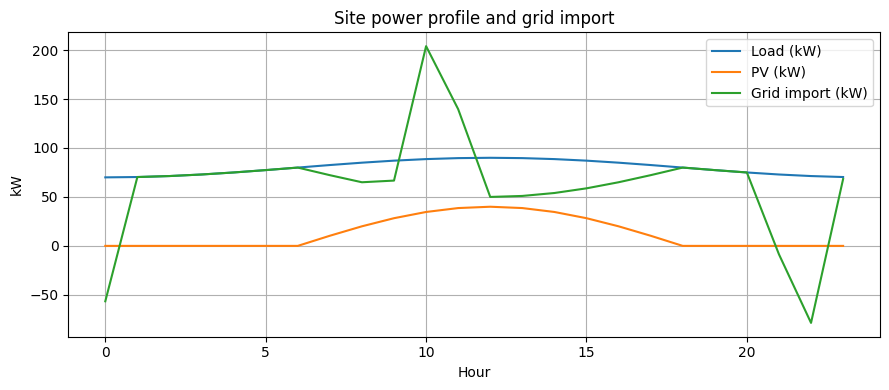

In [25]:
# Plot 1: net grid import vs load and PV
plt.figure(figsize=(9,4))
plt.plot(df["hour"], df["load_kW"], label="Load (kW)")
plt.plot(df["hour"], df["pv_kW"], label="PV (kW)")
plt.plot(df["hour"], df["grid_import_kW"], label="Grid import (kW)")
plt.xlabel("Hour")
plt.ylabel("kW")
plt.title("Site power profile and grid import")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

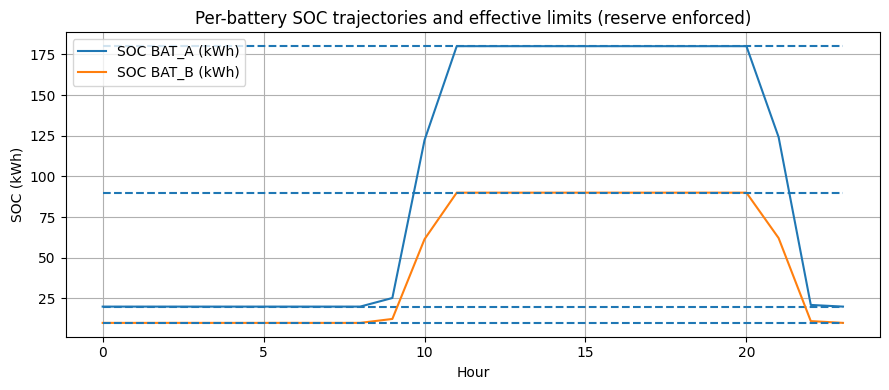

In [26]:
# Plot 2: SOC trajectories per battery (single plot per guidance)
plt.figure(figsize=(9,4))
for i,b in enumerate(batteries):
    plt.plot(df["hour"], df[f"soc_{b['id']}_kWh"], label=f"SOC {b['id']} (kWh)")
    # plot effective SOC limits as dashed lines
    E = b["capacity_kWh"]
    reserve = b["reserve_kWh"]
    soc_min_eff = b["soc_min"] * E + reserve/2.0
    soc_max_eff = b["soc_max"] * E - reserve/2.0
    plt.hlines([soc_min_eff, soc_max_eff], 0, T-1, linestyles='dashed')
plt.xlabel("Hour")
plt.ylabel("SOC (kWh)")
plt.title("Per-battery SOC trajectories and effective limits (reserve enforced)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

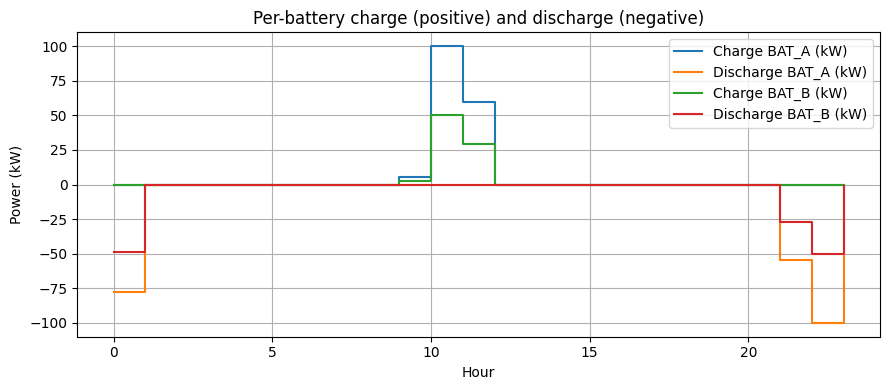

In [27]:
# Plot 3: per-battery charge/discharge schedule
plt.figure(figsize=(9,4))
for i,b in enumerate(batteries):
    plt.step(df["hour"], df[f"ch_{b['id']}_kW"], where='post', label=f"Charge {b['id']} (kW)")
    plt.step(df["hour"], -df[f"dis_{b['id']}_kW"], where='post', label=f"Discharge {b['id']} (kW)")
plt.xlabel("Hour")
plt.ylabel("Power (kW)")
plt.title("Per-battery charge (positive) and discharge (negative)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()